# *Using RNN for System Identification*

Two popular recurrent neural networks (RNNs) are the Long Short-TermMemory (LSTM) and Gated Recurrent Unit (GRU). In this experiment is shown how an LSTM, GRU, and a simple RNN can be used for system identification. 

Consider a dynamical system given by 

\begin{equation}x(k+1) = Ax(k)+ Bu(k)  \end{equation}
\begin{equation}y(k) = Cx(k) + Du(k)  \end{equation}

where the matrices $A, B, C,$ and $D$ are unknown. 

Given the sequence of the input-output data ${(u(k_0),y(k_0)),(u(k_1),y(k_1)),…,(u(k_N),y(k_N))}$, where N is the length of the sequence, we can estimate $A, B, C,$ and $D$ by using a RNN. 

## Necessary packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
import control as control
from control.matlab import *           
from control import lqr
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import GRU
from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.optimizers import RMSprop
from keras.layers import TimeDistributed
from keras.callbacks import ModelCheckpoint

## Ball beam system implementation


***Consider the ball beam dynamics:***

\begin{eqnarray}
    \frac{d^2}{dt^2} x(t) &= & \frac{m_{ball}\,g\, r_{arm} R^2}{L_{beam}(m_{ball}\,R^2 + J_{ball})} sin(\phi(t)) \nonumber\\
    \frac{d^2}{dt^2} \phi(t)& =& -\frac{1}{\tau} \dot{\phi} + \frac{K_s}{V_{in}}, 
\end{eqnarray}
where $x$ is the ball position and $\phi$ is the angle of the beam, and $m_{ball}=0.064\,kg$ is the ball mass, $g=9.81\, m/s^2$ is the gravitational constant, $L_{beam}=0.4255\, m$ is the beam length, $r_{arm}=0.0254\,m$ is the distance between screw and motor gear, $R=0.0127m$ is ball radius, 
$Jb= 4.129\times10^{-6}\, kg \cdot m^2$ is the moment of inertia of the ball, $K_s=1.5286\, rad/sV$, represents the steady state gain, $\tau= 0.0248\, s$ is the time constant and $V_{in}$ is input voltage of motor.  

The equation can be written as, 
\begin{eqnarray}
\dot{x_1} &= & x_2 \nonumber\\
\dot{x_2} &= & \frac{m_{ball}\,g\, r_{arm} R^2}{L_{beam}(m_{ball}\,R^2 + J_{ball})} sin(x_3) \\
\dot{x_3} &= & x_4 \nonumber\\
\dot{x_4} &= & -\frac{1}{\tau} x_4 + \frac{K_s}{V_{in}} \nonumber
\end{eqnarray}
with assumption	$(x_1\, , x_2, \, x_3, \, x_4)^T = (x, \,\dot{x}, \, \phi, \, \dot{\phi})^T$

Then the state space model (SSM) is given by

\begin{equation}
\left[ \begin{array}{c} 
\dot{x_1} \\ \dot{x_2} \\ \dot{x_3} \\ \dot{x_4}
\end{array} \right] = \left[ \begin{array}{cccc} 
 0 & 1& 0& 0\\
              0 & 0&  \frac{m_{ball}\,g\, r_{arm} R^2}{L_{beam}(m_{ball}\,R^2 + J_{ball})} &0\\
              0& 0& 0& 1\\
              0& 0&0& -\frac{1}{\tau}
\end{array} \right] \left[ \begin{array}{c} 
x_1 \\ x_2 \\ sin(x_3) \\ x_4
\end{array} \right] + \left[ \begin{array}{c} 
0 \\0 \\ 0 \\ \frac{K_s}{V_{in}}
\end{array} \right]
\end{equation}

\begin{equation}
y = \left[\begin{array}{cccc} 1&0 &0&0&0 \end{array} \right]  \left[ \begin{array}{c} 
x_1 \\ x_2 \\ sin(x_3) \\ x_4
\end{array} \right]
\end{equation}

In [ ]:
# System parameters 
Lbeam= 0.4255
r_arm=0.0254
R=0.0127
g=9.81
m= 0.064
Jb= 4.129*10**(-6)
Kl=1.5286
tau= 0.0248
const = (m*r_arm*g*R**2)/(Lbeam*(m*R**2 +Jb))
# State space dynamics
A = np.matrix([[0, 1, 0, 0],
              [0, 0, const ,0],
              [0, 0, 0, 1],
              [0, 0, 0, -1/tau]])
B = np.matrix([[0],
              [0],
              [0],
              [61.6371]])
C=np.matrix([[1, 0, 0 ,0]])
D=0
# Number of time-samples
time=20    
# Sampling time for the discretization                           
sampling=0.01
# An initial state for simulation                         
X0=np.array([[0.2125, 0, -0.9774, 0 ]]).T 

## LQR control

In [ ]:
# LQR cost matrices
Q = np.array([[0.1, 0, 0 ,0], [0, 0.1, 0 ,0], [1, 1, 0.1 ,1], [0, 0, 0 ,0.1]], dtype=np.float)
R = np.array([[0.01]], dtype=np.float)
# Obtain LQR controlelr gain and cost-to-go matrix
Kn, Pn, EE = lqr(A, B, Q, R)  

## Discretization with backward Euler

In [ ]:
def backward_Euler_model(A,B,C,initial_state,input_sequence, time_steps,sampling_period):
    #function simulates the state-space model using the backward Euler method
    I=np.identity(A.shape[0]) 
    Ad=inv(I-sampling_period*A)
    Bd=Ad*sampling_period*B
    states=np.zeros(shape=(A.shape[0],time_steps+1))
    output=np.zeros(shape=(C.shape[0],time_steps+1))
    control_law=np.zeros(shape=(B.shape[0],time_steps+1))
    for i in range(0,time_steps):
       if i==0:
           states[:,[i]]=initial_state
           u=-states[:,[i]]*input_sequence
           output[:,[i]]=C*initial_state
           x=Ad*initial_state+u*Bd
       else:
           states[:,[i]]=x
           u=-states[:,[i]]*input_sequence
           output[:,[i]]=C*x
           x=Ad*x+u*Bd
    states[:,[-1]]=x
    output[:,[-1]]=C*x
    control_law[:,[-1]] =-input_sequence*x
    return states, output, control_law

## Discrete system simulation 


Text(0.5, 1.0, 'System with LQR control response')

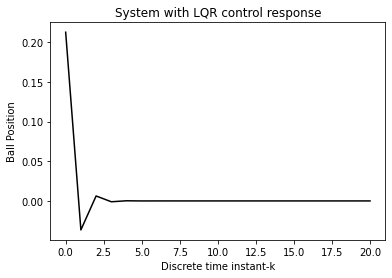

In [ ]:
state,output, U=backward_Euler_model(A,B,C,X0,Kn, time ,sampling)    
plt.plot(output[0,:], 'k')
plt.xlabel('Discrete time instant-k')
plt.ylabel('Ball Position')
plt.title('System with LQR control response')

## System identification with RNNs

We assumed that the matrices $A, B, C,$ and $D$ are unknown, and all that we have is a sequence of the input-output data ${(u(k_0),y(k_0)),(u(k_1),y(k_1)),…,(u(k_N),y(k_N))}$. 

In [ ]:
#####################################Create the train data
uk_train=Kn                         #Define an input sequence for the simulation
x0_train=np.random.rand(4,1)        #Define an initial state for simulation
                                    #Here we simulate the dynamics
state,output_train, U=backward_Euler_model(A,B,C,x0_train,uk_train, time ,sampling)  
uk_train=U  
output_train=output_train.T
output_train=np.concatenate((output_train, np.zeros(shape=(2,1))), axis=0)
                                    #This is the output data used for training
output_train=np.reshape(output_train,(1,output_train.shape[0],1))
tmp_train=np.concatenate((uk_train, np.zeros(shape=(uk_train.shape[0],1))), axis=1)
tmp_train=np.concatenate((x0_train.T,tmp_train.T), axis=0)
                                    #This is the input data used for training
trainX=np.reshape(tmp_train, (1,tmp_train.shape[0],tmp_train.shape[1]))

#####################################Create the validation data
uk_validate=Kn
x0_validate=np.random.rand(4,1)     #New random initial condition
# create a new ouput sequence by simulating the system 
state_validate,output_validate,UU=backward_Euler_model(A,B,C,x0_validate,uk_validate, time ,sampling)    
output_validate=output_validate.T
output_validate=np.concatenate((output_validate, np.zeros(shape=(2,1))), axis=0)
                                    #This is the output data used for validation
output_validate=np.reshape(output_validate,(1,output_validate.shape[0],1))
uk_validate=UU
tmp_validate=np.concatenate((uk_validate, np.zeros(shape=(uk_validate.shape[0],1))), axis=1)
tmp_validate=np.concatenate((x0_validate.T,tmp_validate.T), axis=0)
validateX=np.reshape(tmp_validate, (1,tmp_validate.shape[0],tmp_validate.shape[1]))

########################################Create the test data
uk_test=Kn 
x0_test=np.random.rand(4,1) #New random initial condition
                            #Create a new ouput sequence by simulating the system 
state_test,output_test, UT=backward_Euler_model(A,B,C,x0_test,uk_test, time ,sampling)    
output_test=output_test.T
output_test=np.concatenate((output_test, np.zeros(shape=(2,1))), axis=0)
                            #This is the output data used for test
output_test=np.reshape(output_test,(1,output_test.shape[0],1))
uk_test=UT
tmp_test=np.concatenate((uk_test, np.zeros(shape=(uk_test.shape[0],1))), axis=1)
tmp_test=np.concatenate((x0_test.T,tmp_test.T), axis=0)
testX=np.reshape(tmp_test, (1,tmp_test.shape[0],tmp_test.shape[1]))

### Network models

1. LSTM

In [ ]:
modelLSTM=Sequential()
modelLSTM.add(LSTM(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
modelLSTM.add(TimeDistributed(Dense(1)))  
modelLSTM.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
filepath="\\python_files\\system_identification\\modelsLSTM\\weights-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
historyLSTM=modelLSTM.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)
testPredictLSTM = modelLSTM.predict(testX)

Epoch 1/2000
1/1 - 0s - loss: 0.0352 - mse: 0.0352 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 2/2000
1/1 - 0s - loss: 0.0337 - mse: 0.0337 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 3/2000
1/1 - 0s - loss: 0.0327 - mse: 0.0327 - val_loss: 0.0013 - val_mse: 0.0013
Epoch 4/2000
1/1 - 0s - loss: 0.0318 - mse: 0.0318 - val_loss: 9.7320e-04 - val_mse: 9.7320e-04
Epoch 5/2000
1/1 - 0s - loss: 0.0310 - mse: 0.0310 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 6/2000
1/1 - 0s - loss: 0.0303 - mse: 0.0303 - val_loss: 9.6068e-04 - val_mse: 9.6068e-04
Epoch 7/2000
1/1 - 0s - loss: 0.0296 - mse: 0.0296 - val_loss: 0.0010 - val_mse: 0.0010
Epoch 8/2000
1/1 - 0s - loss: 0.0290 - mse: 0.0290 - val_loss: 9.5746e-04 - val_mse: 9.5746e-04
Epoch 9/2000
1/1 - 0s - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0011 - val_mse: 0.0011
Epoch 10/2000
1/1 - 0s - loss: 0.0279 - mse: 0.0279 - val_loss: 9.6138e-04 - val_mse: 9.6138e-04
Epoch 11/2000
1/1 - 0s - loss: 0.0274 - mse: 0.0274 - val_loss: 0.0012 - val_mse: 0.001

 2. RNN model

In [ ]:
modelSimpleRNN=Sequential()
modelSimpleRNN.add(SimpleRNN(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
modelSimpleRNN.add(TimeDistributed(Dense(1))) 
modelSimpleRNN.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
filepath="\\python_files\\system_identification\\modelsSimpleRNN\\weights-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
historySimpleRNN=modelSimpleRNN.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)
testPredictSimpleRNN = modelSimpleRNN.predict(testX)

Epoch 1/2000
1/1 - 0s - loss: 0.1533 - mse: 0.1533 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 2/2000
1/1 - 0s - loss: 0.1053 - mse: 0.1053 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 3/2000
1/1 - 0s - loss: 0.0891 - mse: 0.0891 - val_loss: 0.0445 - val_mse: 0.0445
Epoch 4/2000
1/1 - 0s - loss: 0.0778 - mse: 0.0778 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 5/2000
1/1 - 0s - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0425 - val_mse: 0.0425
Epoch 6/2000
1/1 - 0s - loss: 0.0623 - mse: 0.0623 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 7/2000
1/1 - 0s - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0408 - val_mse: 0.0408
Epoch 8/2000
1/1 - 0s - loss: 0.0513 - mse: 0.0513 - val_loss: 0.0401 - val_mse: 0.0401
Epoch 9/2000
1/1 - 0s - loss: 0.0469 - mse: 0.0469 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 10/2000
1/1 - 0s - loss: 0.0430 - mse: 0.0430 - val_loss: 0.0384 - val_mse: 0.0384
Epoch 11/2000
1/1 - 0s - loss: 0.0395 - mse: 0.0395 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 12/2000
1/1 - 0s - loss:

3. GRU model

In [ ]:
modelGRU=Sequential()
modelGRU.add(GRU(32, input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
modelGRU.add(TimeDistributed(Dense(1))) 
modelGRU.compile(optimizer=RMSprop(), loss='mean_squared_error', metrics=['mse'])
filepath="\\python_files\\system_identification\\modelsGRU\\weights-{epoch:02d}-{val_loss:.6f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
callbacks_list = [checkpoint]
historyGRU=modelGRU.fit(trainX, output_train , epochs=2000, batch_size=1, callbacks=callbacks_list, validation_data=(validateX,output_validate), verbose=2)
testPredictGRU = modelGRU.predict(testX)

Epoch 1/2000
1/1 - 0s - loss: 0.0214 - mse: 0.0214 - val_loss: 0.0020 - val_mse: 0.0020
Epoch 2/2000
1/1 - 0s - loss: 0.0198 - mse: 0.0198 - val_loss: 6.9527e-04 - val_mse: 6.9527e-04
Epoch 3/2000
1/1 - 0s - loss: 0.0177 - mse: 0.0177 - val_loss: 7.2149e-04 - val_mse: 7.2149e-04
Epoch 4/2000
1/1 - 0s - loss: 0.0164 - mse: 0.0164 - val_loss: 5.6900e-04 - val_mse: 5.6900e-04
Epoch 5/2000
1/1 - 0s - loss: 0.0153 - mse: 0.0153 - val_loss: 5.3066e-04 - val_mse: 5.3066e-04
Epoch 6/2000
1/1 - 0s - loss: 0.0143 - mse: 0.0143 - val_loss: 4.6668e-04 - val_mse: 4.6668e-04
Epoch 7/2000
1/1 - 0s - loss: 0.0135 - mse: 0.0135 - val_loss: 4.2744e-04 - val_mse: 4.2744e-04
Epoch 8/2000
1/1 - 0s - loss: 0.0127 - mse: 0.0127 - val_loss: 3.8699e-04 - val_mse: 3.8699e-04
Epoch 9/2000
1/1 - 0s - loss: 0.0119 - mse: 0.0119 - val_loss: 3.5777e-04 - val_mse: 3.5777e-04
Epoch 10/2000
1/1 - 0s - loss: 0.0112 - mse: 0.0112 - val_loss: 3.3127e-04 - val_mse: 3.3127e-04
Epoch 11/2000
1/1 - 0s - loss: 0.0106 - mse: 0.

### Figures 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


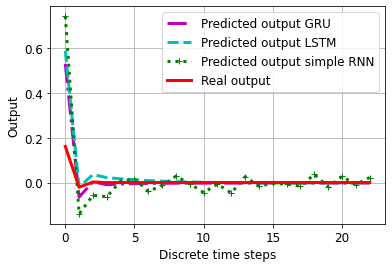

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


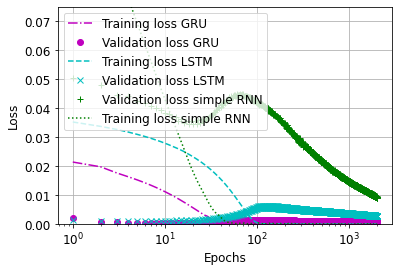

In [ ]:
plt.figure(figsize=(6, 4))
plt.rcParams.update({'font.size': 12}) 
plt.plot(testPredictGRU[0,:,0], 'm-.', linewidth=3.0, label='Predicted output GRU')
plt.plot(testPredictLSTM[0,:,0], 'c--', linewidth=3.0, label='Predicted output LSTM')
plt.plot(testPredictSimpleRNN[0,:,0], 'g:+', linewidth=3.0, label='Predicted output simple RNN')
plt.plot(output_test[0,:],'r-', linewidth=3.0, label='Real output')
plt.xlabel('Discrete time steps')
plt.ylabel('Output')
plt.legend()
plt.grid(True)
plt.show()

lossGRU=historyGRU.history['loss']
val_lossGRU=historyGRU.history['val_loss']
lossLSTM=historyLSTM.history['loss']
val_lossLSTM=historyLSTM.history['val_loss']
lossSimpleRNN=historySimpleRNN.history['loss']
val_lossSimpleRNN=historySimpleRNN.history['val_loss']
epochs=range(1,len(loss)+1)
plt.figure()
plt.plot(epochs, lossGRU, 'm-.', label='Training loss GRU')
plt.plot(epochs, val_lossGRU,'mo', label='Validation loss GRU')
plt.plot(epochs, lossLSTM,'c--', label='Training loss LSTM')
plt.plot(epochs, val_lossLSTM,'cx', label='Validation loss LSTM')
plt.plot(epochs, val_lossSimpleRNN,'g+', label='Validation loss simple RNN')
plt.plot(epochs, lossSimpleRNN,'g:', label='Training loss simple RNN')
plt.ylim(0,0.075)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xscale('log')
plt.grid(True)
plt.legend()
plt.show()